In [186]:
import requests
import json
import time

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Plot Voronoi diagram for the stations to show approximate coverage of each.
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi,voronoi_plot_2d

%matplotlib inline

# Weather Data
There are many sources for weather data, but we chose to use the NOAA NCDC Integrated Surface Data, which is available on an hourly basis, and despite the archaic structure, is a very trustworthy source. This notebook shows how to parse and format this data. `isd-history.csv` was downloaded from the [NCDC website](ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.csv), but is provided in this repository.

In [187]:
stations = pd.read_csv('isd-history.csv',parse_dates=['BEGIN','END'])
# Weather records are queried by a concatenation of USAF and WBAN.
stations['station_id'] = stations.apply(lambda x: str(x['USAF'])+str(x['WBAN']), axis=1)
stations = stations.set_index('station_id')
stations.head()

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
station_id,,,,,,,,,,,
00701899999,007018,99999,WXPOD 7018,NaN,NaN,NaN,0.00,0.000,7018.0,2011-03-09,2013-07-30
00702699999,007026,99999,WXPOD 7026,AF,NaN,NaN,0.00,0.000,7026.0,2012-07-13,2017-08-22
00707099999,007070,99999,WXPOD 7070,AF,NaN,NaN,0.00,0.000,7070.0,2014-09-23,2015-09-26
00826099999,008260,99999,WXPOD8270,NaN,NaN,NaN,0.00,0.000,0.0,2005-01-01,2012-07-31
00826899999,008268,99999,WXPOD8278,AF,NaN,NaN,32.95,65.567,1156.7,2010-05-19,2012-03-23


In [188]:
utah_stations = stations[stations.STATE == 'TX'] #KGRK
utah_stations.head()

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
station_id,,,,,,,,,,,
69019013910,690190,13910,ABILENE DYESS AFB,US,TX,KDYS,32.433,-99.850,545.3,1943-12-01,1997-12-31
69019099999,690190,99999,DYESS AFB/ABILENE,US,TX,NaN,32.417,-99.850,545.0,2000-01-03,2004-12-30
69028099999,690280,99999,PORT ISABEL (CGS),US,TX,NaN,26.067,-97.167,5.0,1982-06-27,1983-11-16
69029099999,690290,99999,PORT ARANSAS,US,TX,NaN,27.833,-97.067,2.0,1982-06-25,2004-11-29
69283499999,692834,99999,CAMP SPANN,AF,TX,KQSP,36.650,66.983,408.0,1985-12-14,1985-12-14


,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
station_id,,,,,,,,,,,
72011053983,720110,53983,LLANO MUNICIPAL AIRPORT,US,TX,KAQO,30.784,-98.662,335.9,2005-01-01,2022-12-28
7201513049,720151,3049,ALPINE-CASPARIS MUNI ARPT,US,TX,KE38,30.383,-103.683,1375.6,2006-01-01,2022-12-28
72026153976,720261,53976,BRIDGEPORT MUNICIPAL ARPT,US,TX,KXBP,33.175,-97.828,259.4,2006-01-01,2022-12-28
72026912982,720269,12982,BROOKS COUNTY AIRPORT,US,TX,KBKS,27.207,-98.121,34.1,2006-01-01,2022-12-28
7202713044,720271,3044,BIG SRNG MCMHN-WRKLE ARPT,US,TX,KBPG,32.213,-101.521,784.3,2006-01-01,2022-12-28


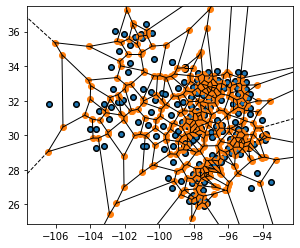

In [189]:
# Let's get stations that are valid for all of our time range. Not perfect, but we don't want to deal with interpolating missing data
start = pd.Timestamp(2010,1,1)
end = pd.Timestamp(2018,1,1)
valid_stations = utah_stations[(utah_stations.BEGIN < start) & (utah_stations.END > start)]
plt.figure()

lons = valid_stations.LON.values
lats = valid_stations.LAT.values
plt.plot(lons, lats,'ko')


vor = Voronoi(np.vstack((lons,lats)).T)
voronoi_plot_2d(vor,ax=plt.gca())
plt.gca().set_aspect(1)
valid_stations.head()

In [190]:
valid_stations = valid_stations[valid_stations["ICAO"] == "KATT"] #This is the weather station from Austin that we are interested on

In [191]:
valid_stations#shape

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
station_id,,,,,,,,,,,
72254413958,722544,13958,AUSTIN-CAMP MABRY,US,TX,KATT,30.321,-97.76,204.2,1999-06-02,2022-12-28


In [192]:
stations = valid_stations.index.values.tolist()
valid_stations.to_csv('utah_stations.csv')

## Pulling weather data.
Mostly self explanatory, see [API docs](https://www.ncei.noaa.gov/support/access-data-service-api-user-documentation) for more details. The dataType codes are documented 
[here](ftp://ftp.ncdc.noaa.gov/pub/data/noaa/ish-format-document.pdf)

In [193]:
url = 'https://www.ncei.noaa.gov/access/services/data/v1' #

params = {
    'dataset': 'global-hourly',
    'startDate': '2017-09-26T00:00:00',
    'endDate': str(pd.to_datetime(datetime.utcnow()).strftime('%Y-%m-%dT%H:%M:%S')),
    'dataTypes':'AA1,AA1,AA2,AA3,TMP,VIS,WND,AJ1,AT1,AT2,AT3,AT4,AT5,AT6,AT7,AT8',
    'stations': stations,
    'format': 'json'
    
}

weather_data = pd.DataFrame()

for station in stations:
    params['stations'] = station
    print('Station:',station)
    res = requests.get(url,params=params)
    js = res.json()
    print(len(js))
    try:
        weather_data = weather_data.append(js)
    except:
        print ("Empty for station",station)
    time.sleep(0.5)


Station: 72254413958
63839


C:\Users\migue\AppData\Local\Temp/ipykernel_121172/259290788.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weather_data = weather_data.append(js)


In [194]:
# weather_data.to_csv('Austin_weather_2017_to_2023.csv')

In [195]:
weather_data

,DATE,REPORT_TYPE,AA1,VIS,QUALITY_CONTROL,STATION,TMP,SOURCE,WND,CALL_SIGN,AA2,AJ1,AT1,AT3,AT2,AA3,AT4,AT5,AT6
0,2017-09-26T00:51:00,FM-15,"01,0000,9,5","016093,5,N,5",V030,72254413958,"+0261,5",7,"999,9,C,0000,5",KATT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-09-26T01:51:00,FM-15,"01,0000,9,5","016093,5,N,5",V030,72254413958,"+0267,5",7,"999,9,V,0021,5",KATT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-09-26T02:51:00,FM-15,"01,0000,9,5","016093,5,N,5",V030,72254413958,"+0267,5",7,"130,5,N,0036,5",KATT,"03,0000,2,1",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-09-26T03:51:00,FM-15,"01,0000,9,5","016093,5,N,5",V030,72254413958,"+0261,5",7,"120,5,N,0026,5",KATT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-09-26T04:51:00,FM-15,"01,0000,9,5","016093,5,N,5",V030,72254413958,"+0256,5",7,"130,5,N,0021,5",KATT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63834,2022-12-31T19:51:00,FM-15,NaN,"016093,1,9,9",V020,72254413958,"+0250,2",4,"220,1,N,0046,1",99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63835,2022-12-31T20:51:00,FM-15,NaN,"016093,1,9,9",V020,72254413958,"+0250,1",4,"220,1,N,0051,1",99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63836,2022-12-31T21:51:00,FM-15,NaN,"016093,1,9,9",V020,72254413958,"+0244,1",4,"210,1,N,0057,1",99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63837,2022-12-31T22:51:00,FM-15,NaN,"016093,1,9,9",V020,72254413958,"+0233,1",4,"999,9,V,0031,1",99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Extracting/Converting Weather Features
As mentioned before, the format specification has been around a while. This block reformats the data in a useful format. 

In [196]:

def parseWindDir(x):
    # Wind direction, deg or 999
    d = x.split(',')[0]
    if d == '999':
        return np.nan
    return float(d)


def parseWindSpeed(x):
    s = x.split(',')[3]
    if s == '9999':
        return 0.0
    return float(s) / 10.0

def parseVisibility(x):
    v = x.split(',')[0]
    if v == '999999':
        return 16093.0
    return float(v)

def parseTemp(x):
    t = x.split(',')[0]
    if t == '+9999':
        return np.nan
    return float(t) / 10.0

def parseSnowDepth(x):
    try:
        t = x.split(',')[0]
    except:
        return 0.0

    if t == '9999':
        return 0.0
    return float(t) 

def parsePrecip(x):
    try:
        p = x.split(',')[1]
        return float(p) / 10.0
    except:
        return 0.0

weather_lut = {
    '01': 'fog',
    '02': 'fog',
    '03': 'thunder',
    '04': 'sleet/hail',
    '05': 'hail',
    '06': 'glaze',
    '07': 'dust',
    '08': 'smoke',
    '09': 'blowing_snow',
    '10': 'tornado',
    '11': 'winds',
    '12': 'spray',
    '13': 'mist',
    '14': 'drizzle',
    '15': 'freezing_drizzle',
    '16': 'rain',
    '17': 'freezing_rain',
    '18': 'snow',
    '19': 'unknown_precipitation',
    '21': 'ground_fog',
    '22': 'ice_fog'
}
def parseWeatherType(x):
    try:
        p = x.split(',')[1]
    except:
        return x
    return weather_lut[p]
        


weather_data['DATE'] = pd.to_datetime(weather_data["DATE"])
weather_data['wind_dir'] = weather_data.WND.apply(parseWindDir)
weather_data['wind_speed'] = weather_data.WND.apply(parseWindSpeed)
weather_data['visibility'] = weather_data.VIS.apply(parseVisibility)
weather_data['temperature'] = weather_data.TMP.apply(parseTemp)
weather_data['precip_01'] = weather_data.AA1.apply(parsePrecip)
weather_data['precip_02'] = weather_data.AA2.apply(parsePrecip)
weather_data['precip_03'] = weather_data.AA3.apply(parsePrecip)
weather_data['precip_depth'] = weather_data[['precip_01','precip_02','precip_03']].max(axis=1)
weather_data['snow_depth'] = weather_data.AJ1.apply(parseSnowDepth)
weather_data['AT1'] = weather_data.AT1.apply(parseWeatherType)
weather_data['AT2'] = weather_data.AT2.apply(parseWeatherType)
weather_data['AT3'] = weather_data.AT3.apply(parseWeatherType)
weather_data['AT4'] = weather_data.AT4.apply(parseWeatherType)
weather_data['AT5'] = weather_data.AT5.apply(parseWeatherType)
weather_data['AT6'] = weather_data.AT6.apply(parseWeatherType)
# weather_data['AT7'] = weather_data.AT7.apply(parseWeatherType)
# weather_data['AT8'] = weather_data.AT8.apply(parseWeatherType)

weather_types = weather_data[['AT1','AT2','AT3','AT4','AT5','AT6']]#,'AT7','AT8']]

weather_data['snowing'] = weather_types.apply(lambda x: x.isin(['snow'])).any(axis=1)
weather_data['raining'] = weather_types.apply(lambda x: x.isin(['rain','freezing_rain','drizzle','freezing_drizzle'])).any(axis=1)
weather_data['foggy'] = weather_types.apply(lambda x: x.isin(['fog','ground_fog','ice_fog'])).any(axis=1)
weather_data['thunderstorm'] = weather_types.apply(lambda x: x.str.contains('thunder')).any(axis=1)
weather_data['hailing'] = weather_types.apply(lambda x: x.isin(['sleet/hail','hail'])).any(axis=1)
weather_data['icy'] = weather_types.apply(lambda x: x.isin(['glaze','freezing_rain,freezing_drizzle','ice_fog','snow'])).any(axis=1)
weather_data['station_id'] = weather_data.STATION

# Drop parsed columns
weather_data = weather_data.drop(['WND','VIS','AA1','AA2','AA3','precip_01','precip_02','precip_03','AJ1'],axis=1)
weather_data = weather_data.drop(['TMP','AT1','AT2','AT3','AT4','AT5','AT6','SOURCE','REPORT_TYPE','QUALITY_CONTROL','STATION'],axis=1)

In [197]:
weather_data.head()

,DATE,CALL_SIGN,wind_dir,wind_speed,visibility,temperature,precip_depth,snow_depth,snowing,raining,foggy,thunderstorm,hailing,icy,station_id
0,2017-09-26 00:51:00,KATT,NaN,0.0,16093.0,26.1,0.0,0.0,False,False,False,False,False,False,72254413958
1,2017-09-26 01:51:00,KATT,NaN,2.1,16093.0,26.7,0.0,0.0,False,False,False,False,False,False,72254413958
2,2017-09-26 02:51:00,KATT,130.0,3.6,16093.0,26.7,0.0,0.0,False,False,False,False,False,False,72254413958
3,2017-09-26 03:51:00,KATT,120.0,2.6,16093.0,26.1,0.0,0.0,False,False,False,False,False,False,72254413958
4,2017-09-26 04:51:00,KATT,130.0,2.1,16093.0,25.6,0.0,0.0,False,False,False,False,False,False,72254413958


<AxesSubplot: xlabel='DATE'>

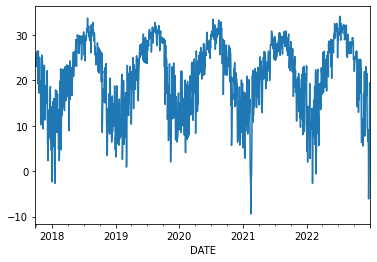

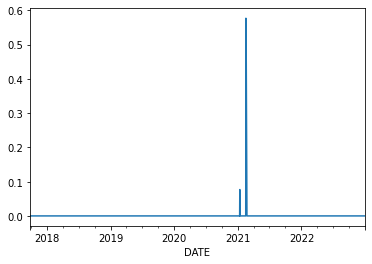

<Figure size 432x288 with 0 Axes>

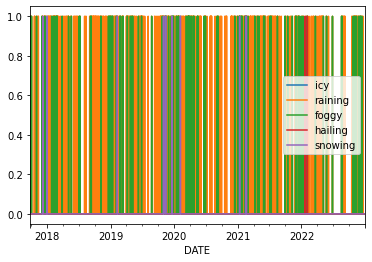

In [198]:
ts = weather_data.set_index('DATE').temperature.resample('1d').mean()
ts.plot()
ts = weather_data.set_index('DATE').snow_depth.resample('1d').mean()
plt.figure()
ts.plot()
ts = weather_data.set_index('DATE')[['icy','raining','foggy','hailing','snowing']].resample('1d').sum()
plt.figure()
ts.plot()

In [199]:
weather_data['timestamp'] = pd.to_datetime(weather_data.DATE)

In [200]:
time_index = pd.DatetimeIndex(weather_data['timestamp'])

In [201]:
weather_data.head()

,DATE,CALL_SIGN,wind_dir,wind_speed,visibility,temperature,precip_depth,snow_depth,snowing,raining,foggy,thunderstorm,hailing,icy,station_id,timestamp
0,2017-09-26 00:51:00,KATT,NaN,0.0,16093.0,26.1,0.0,0.0,False,False,False,False,False,False,72254413958,2017-09-26 00:51:00
1,2017-09-26 01:51:00,KATT,NaN,2.1,16093.0,26.7,0.0,0.0,False,False,False,False,False,False,72254413958,2017-09-26 01:51:00
2,2017-09-26 02:51:00,KATT,130.0,3.6,16093.0,26.7,0.0,0.0,False,False,False,False,False,False,72254413958,2017-09-26 02:51:00
3,2017-09-26 03:51:00,KATT,120.0,2.6,16093.0,26.1,0.0,0.0,False,False,False,False,False,False,72254413958,2017-09-26 03:51:00
4,2017-09-26 04:51:00,KATT,130.0,2.1,16093.0,25.6,0.0,0.0,False,False,False,False,False,False,72254413958,2017-09-26 04:51:00


## Aggregate

In [202]:
aggs = {
    'snowing': 'any',
    'raining': 'any',
    'foggy': 'any',
    'icy': 'any',
    'hailing': 'any',
    'thunderstorm':'any',
    'wind_speed': 'mean',
    'visibility': 'mean',
    'temperature': 'mean',
    'precip_depth':'mean',
    'snow_depth':'mean'
}

In [203]:
resamp = pd.DataFrame()
station_ids = list(set(weather_data.station_id.tolist()))
for _id in station_ids:
    idx = weather_data.station_id == _id
    ti = time_index[idx]

    wdfi = weather_data[idx].set_index(ti)
    floating = wdfi[['visibility','temperature','wind_speed','precip_depth','snow_depth']]
    binaries = wdfi[['snowing','raining','foggy','icy','hailing','thunderstorm']]
    b = binaries.resample('1h').apply(lambda x: x.any())
    f = floating.resample('1h').agg({
        'wind_speed': 'mean',
        'visibility': 'mean',
        'temperature': 'mean',
        'precip_depth':'mean',
        'snow_depth':'mean'
    })

    temp = pd.concat((f,b),axis=1)
    temp['station_id'] = _id
    resamp = resamp.append(temp)

C:\Users\migue\AppData\Local\Temp/ipykernel_121172/2443991264.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resamp = resamp.append(temp)


In [204]:
for f in ['visibility','temperature','wind_speed','precip_depth','snow_depth']:
    resamp.loc[pd.isna(resamp[f]),f] = np.nanmedian(resamp[f])
for f in ['snowing','raining','foggy','icy','hailing','thunderstorm']:
    resamp.loc[pd.isna(resamp[f]),f] = 0

In [205]:
#Booleans to 0/1
weather_data[['snowing','raining','foggy','thunderstorm','hailing','icy']] = weather_data[['snowing', 'raining','foggy', 'thunderstorm', 'hailing', 'icy']].astype(int)

In [206]:
weather_data.to_csv("Z:\Clases\CLASE\Master Rochester\Fall_2022\InterviewPrep\ReadAustinData\weather_data_noaa.csv")